In [1]:
%autosave 0
import numpy 
import matplotlib.pyplot as plt
import pickle
import pandas as pd
import numpy as np 
import tensorflow as tf
from pandas import read_csv
from matplotlib import pyplot
from pandas.plotting import scatter_matrix 
from numpy import set_printoptions 
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer
from xgboost import XGBRFRegressor, XGBRegressor
from sklearn.compose import ColumnTransformer

set_printoptions(precision=0)
pd.set_option("display.precision", 2)
pd.option_context('display.float_format', '{:0f}'.format);

seed = 15
#tf.random.set_seed(seed)
tf.set_random_seed(seed)
numpy.random.seed(seed)

Autosave disabled


In [2]:
# Importation du fichier csv dans un dataframe
# df_train_full = read_csv( './dataset-template.csv', index_col=0)
df_train_full = read_csv( './csv/realstate-data.csv', index_col=0)

In [3]:
print(df_train_full.shape)
df_train_full.head(5)

(7200, 11)


,city,county,district,area_m2,ground_m2,nb_room,nb_bedroom,pool,cellar,garage,output
ref,,,,,,,,,,,
/fr/properties/30731a-133656.htm,Saint-Maurin,Lot-et-Garonne,Aquitaine,100.0,NaN,5.0,3.0,NaN,NaN,NaN,210000
/fr/properties/88486a-95148cj265.htm,Castelnau-de-Médoc,Gironde,Aquitaine,328.0,3700.0,9.0,4.0,NaN,NaN,True,840000
/fr/properties/44945a-m728.htm,Peyrehorade,Landes,Aquitaine,814.0,100000.0,19.0,8.0,True,True,NaN,1950000
/fr/properties/32488a-2534.htm,Bourlens,Lot-et-Garonne,Aquitaine,406.0,13200.0,14.0,10.0,NaN,NaN,NaN,975200
/fr/properties/32488a-2557.htm,Monsempron-Libos,Lot-et-Garonne,Aquitaine,99.0,35.0,4.0,3.0,NaN,NaN,NaN,101520


In [4]:
df_train_full.describe()

,area_m2,ground_m2,nb_room,nb_bedroom,output
count,6880.00,5.74e+03,6311.00,6221.00,7.20e+03
mean,313.85,2.45e+04,7.10,4.52,4.53e+05
std,1052.33,3.63e+05,3.77,2.34,6.30e+05
min,1.00,1.00e+00,2.00,2.00,8.00e+03
25%,125.00,1.11e+03,5.00,3.00,1.98e+05
50%,180.00,3.00e+03,6.00,4.00,3.11e+05
75%,280.00,9.48e+03,8.00,5.00,4.98e+05
max,29760.00,2.69e+07,70.00,50.00,1.60e+07


In [5]:
Y_trainfull = df_train_full['output']
X_trainfull = df_train_full.drop('output', axis=1)

In [6]:
print(Y_trainfull.shape)
print(X_trainfull.shape)

(7200,)
(7200, 10)


# Traitement des variables catégorielles

In [7]:
cat_columns = ['city', 'county', 'district']

X_trainfull = pd.get_dummies(X_trainfull, columns = cat_columns)

one = OneHotEncoder(categories = [X_trainfull['city'].unique()])
one.fit_transform(pd.DataFrame(X_trainfull['city']))

X_trainfull['city'].unique()[0]

In [8]:
city_pipe = Pipeline(steps=[
    ('one', OneHotEncoder(categories = [X_trainfull['city'].unique()]))
])

In [9]:
county_pipe = Pipeline(steps=[
    ('one', OneHotEncoder(categories = [X_trainfull['county'].unique()]))
])

In [10]:
district_pipe = Pipeline(steps=[
    ('one', OneHotEncoder(categories = [X_trainfull['district'].unique()]))
])

# Traitement des valeurs manquantes

In [11]:
df_train_full.isna().any()

city          False
county        False
district      False
area_m2        True
ground_m2      True
nb_room        True
nb_bedroom     True
pool           True
cellar         True
garage         True
output        False
dtype: bool

In [12]:
boolean_columns = ['pool', 'cellar', 'garage']
area_column = ['area_m2']
ground_column = ['ground_m2']
nb_room_column = ['nb_room']
nb_bedroom_column = ['nb_bedroom']

In [13]:
boolean_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0)),
    ('imputer1', SimpleImputer(missing_values='True', strategy='constant', fill_value=1))
])

In [14]:
area_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median'))
])

In [15]:
ground_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=0))
])

In [16]:
room_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=1))
])

In [17]:
bedroom_pipe = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value=1))
])

# Construction du pipeline de pré-traitement

In [18]:
preprocess_pipe = ColumnTransformer(transformers=[
    ('city', city_pipe, ['city']),
    ('county', county_pipe, ['county']),
    ('district', district_pipe, ['district']),
    ('bool', boolean_pipe, boolean_columns),
    ('area', area_pipe, area_column),
    ('ground', ground_pipe, ground_column),
    ('room', room_pipe, nb_room_column),
    ('bedroom', bedroom_pipe, nb_bedroom_column),
])

# Choix du modèle et intégration dans la pipeline

In [19]:
def mae_model(preprocess_pipe, model):

    full_pipe = Pipeline(steps=[
        ('pp', preprocess_pipe),
        ('model', model)
    ])

    X_train, X_val, Y_train, Y_val = train_test_split(X_trainfull, Y_trainfull, random_state = seed)

    full_pipe.fit(X_train, Y_train);

    y_train_pred = full_pipe.predict(X_train)
    y_val_pred = full_pipe.predict(X_val)

    mae_train = round(metrics.mean_absolute_error(Y_train, y_train_pred), 0)
    mae_val = round(metrics.mean_absolute_error(Y_val, y_val_pred), 0)

    return mae_train, mae_val

In [20]:
lin = LinearRegression()
log = LogisticRegression()
tree = DecisionTreeRegressor()
rf = RandomForestRegressor()
bag = BaggingRegressor()
xgb = XGBRegressor()
xgb_rf = XGBRFRegressor()

In [21]:
models = [lin, log, tree, rf, bag, xgb, xgb_rf]

In [22]:
errors = []
for model in models:
    errors += [mae_model(preprocess_pipe, model)]

C:\Users\Utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\sklearn\svm\base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
C:\Users\Utilisateur\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.ba

[16:55:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


C:\Users\Utilisateur\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


[16:55:44] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


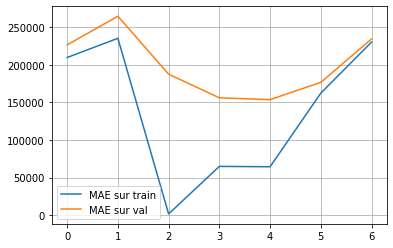

In [23]:
plt.plot(errors);
plt.grid();
plt.legend(['MAE sur train', 'MAE sur val']);

Du graphique précédent, nous choisissons de conserver le modèle 5 à savoir le modèle xgbregressor

# Génération du modèle retenu

In [24]:
model = XGBRegressor()

In [25]:
full_pipe = Pipeline(steps=[
        ('pp', preprocess_pipe),
        ('model', model)
    ])

In [26]:
 full_pipe.fit(X_trainfull, Y_trainfull);

C:\Users\Utilisateur\Anaconda3\lib\site-packages\xgboost\core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \
C:\Users\Utilisateur\Anaconda3\lib\site-packages\xgboost\core.py:588: FutureWarning: Series.base is deprecated and will be removed in a future version
  data.base is not None and isinstance(data, np.ndarray) \


[16:55:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [27]:
y_train_pred = full_pipe.predict(X_trainfull)

In [28]:
mae_train = round(metrics.mean_absolute_error(Y_trainfull, y_train_pred), 0)
print('MAE sur train : ', mae_train, '€')

MAE sur train :  159358.0 €


In [29]:
pickle.dump(model, open( "model.file", "wb" ))

In [30]:
trainfull_pred = pd.DataFrame(y_train_pred)
trainfull_pred.to_csv('./csv/trainfull_pred.csv', index=False)
Y_trainfull.to_csv('./csv/Y_trainfull.csv', index=False)

C:\Users\Utilisateur\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: FutureWarning: The signature of `Series.to_csv` was aligned to that of `DataFrame.to_csv`, and argument 'header' will change its default value from False to True: please pass an explicit value to suppress this warning.
  This is separate from the ipykernel package so we can avoid doing imports until


In [31]:
full_pipe.predict(pd.DataFrame([['Bordeaux', 'Gironde', 'Aquitaine', '54', '12', '1', '1', '0', '0', '0']]))

KeyError: "None of [Index(['city'], dtype='object')] are in the [columns]"

In [40]:
pd.DataFrame.from_dict(['city':'Bordeaux', 'county':'Gironde', 'district':'Aquitaine',
             'ezrer':54, 'rtret':12, 'sdrg':1, 'hj':1, 'DSF':0, 'JKL':0, 'SDGF':0])

SyntaxError: invalid syntax (<ipython-input-40-820b3e1e17ad>, line 1)